In [1]:
import tensorflow as tf
import numpy as np
import PIL
import IPython.display as display

# tf.train.Example
## tf.Example의 데이터 형식
기본적으로 tf.Example은 {string : tf.train.Feature} 매핑입니다.
tf.train.Feature 메시지 유형은 다음 3가지 유형 중 하나를 허용할 수 있습니다.

### 1. tf.train.ByteList(다음 유형을 강제 변환할 수 있다)
- string
- byte

In [2]:
def _bytes_feature(value):
    # string / byte 로부터 byte_list를 만든다
    # isinstance(변수, 타입) 변수가 타입이 맞는지를 판단해준다. 아래에서는 텐서유형일 경우 변환을 진행하지 않아 넘파이로 변경해주는 작업이다.
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list= tf.train.BytesList(value = [value]))

In [3]:
print(_bytes_feature(b'test_string'))
print(_bytes_feature(u'test_string'.encode('utf-8')))

bytes_list {
  value: "test_string"
}

bytes_list {
  value: "test_string"
}



### 2. tf.train.FloatList
- float (float32)
- double (float64)

In [4]:
def _float_feature(value):
    # float과 double를 float_list로 돌려준다.
    return tf.train.Feature(float_list = tf.train.FloatList(value=[value]))

In [5]:
print(type(np.exp(1)))
print(np.exp(1))
k = _float_feature(np.exp(1))
print(k)

<class 'numpy.float64'>
2.718281828459045
float_list {
  value: 2.7182817459106445
}



### 3. tf.train.Int64List
- bool
- enum
- int32
- unit32
- int64
- uint64

In [6]:
def _int64_feature(value):
    # bool / enum / int / unit 를 int64_list로 리턴한다.
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [7]:
print(_int64_feature(True))
print(_int64_feature(1))
print(_int64_feature(2))

int64_list {
  value: 1
}

int64_list {
  value: 1
}

int64_list {
  value: 2
}



In [8]:
feature = _float_feature(np.exp(1))
print(feature)
print(feature.SerializeToString())

float_list {
  value: 2.7182817459106445
}

b'\x12\x06\n\x04T\xf8-@'


### tf.train.Example 메세지 만들기

In [9]:
n_obervaions = int(1e4)

feature0 = np.random.choice([False, True], n_obervaions)
feature1 = np.random.randint(0, 5, n_obervaions)
strings = np.array([b'dog', b'cat', b'chicken', b'puppy', b'sheep'])
feature2 = strings[feature1]
feature3 = np.random.randn(n_obervaions)

In [10]:
def serialize_example(feature0, feature1, feature2, feature3):
    feature = {
        'feature0' : _int64_feature(feature0),
        'feature1' : _int64_feature(feature1), 
        'feature2' : _bytes_feature(feature2),
        'feature3' : _float_feature(feature3)
    }

    example_proto = tf.train.Example(features = tf.train.Features(feature=feature))
    
    return example_proto.SerializeToString()

In [11]:
serialized_ex = serialize_example(False, 4 , b'dog', 0.9876)
serialized_ex

b'\nQ\n\x13\n\x08feature2\x12\x07\n\x05\n\x03dog\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04[\xd3|?\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x04'

메세지는 tf.train.Example.FromString 메서드를 통해 디코딩할 수 있다.

In [12]:
ex_proto = tf.train.Example.FromString(serialized_ex)
ex_proto

features {
  feature {
    key: "feature0"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "feature1"
    value {
      int64_list {
        value: 4
      }
    }
  }
  feature {
    key: "feature2"
    value {
      bytes_list {
        value: "dog"
      }
    }
  }
  feature {
    key: "feature3"
    value {
      float_list {
        value: 0.9876000285148621
      }
    }
  }
}

### tf.data를 사용한 TFRecord파일

In [13]:
temp = tf.data.Dataset.from_tensor_slices(feature1)

In [14]:
for i in temp.take(2):
    print(i)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)


In [15]:
features_dataset = tf.data.Dataset.from_tensor_slices((feature0, feature1, feature2, feature3))
features_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.bool, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))>

In [16]:
for a,s,d,f in features_dataset.take(1):
    print(a)
    print(s)
    print(d)
    print(f)

tf.Tensor(False, shape=(), dtype=bool)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'dog', shape=(), dtype=string)
tf.Tensor(0.5360787574850894, shape=(), dtype=float64)


In [17]:
features_dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(), dtype=tf.bool, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))>

In [18]:
def tf_serialize_example(a,s,d,f):
    tf_string = tf.py_function(
        serialize_example,
        (a,s,d,f),
        tf.string
    )
    return tf.reshape(tf_string, ())

In [19]:
tf_serialize_example(a,s,d,f)

<tf.Tensor: shape=(), dtype=string, numpy=b'\nQ\n\x13\n\x08feature2\x12\x07\n\x05\n\x03dog\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x00\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04u<\t?\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00'>

In [20]:
serialized_features_dataset = features_dataset.map(tf_serialize_example)

In [21]:
k = serialized_features_dataset.take(3).as_numpy_iterator()
for i in k:
    print(i)

b'\nQ\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x00\n\x13\n\x08feature2\x12\x07\n\x05\n\x03dog\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04u<\t?\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00'
b'\nQ\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04I\x80\x85>\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x13\n\x08feature2\x12\x07\n\x05\n\x03dog'
b'\nU\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\xbe9\x05?\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01\n\x17\n\x08feature2\x12\x0b\n\t\n\x07chicken\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x02'


In [22]:
def generator():
    for features in features_dataset:
        yield serialize_example(*features)

In [23]:
serialized_features_dataset = tf.data.Dataset.from_generator(generator,output_types=tf.string, output_shapes=())
# serialized_features_dataset2 = tf.data.Dataset.from_generator(generator,output_types=tf.string)

In [24]:
serialized_features_dataset

<FlatMapDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

## 파일저장 및 읽기

In [25]:
filename = 'test.tfrecord'
writer = tf.data.experimental.TFRecordWriter(filename)
writer.write(serialized_features_dataset)

Instructions for updating:
To write TFRecords to disk, use `tf.io.TFRecordWriter`. To save and load the contents of a dataset, use `tf.data.experimental.save` and `tf.data.experimental.load`


In [26]:
raw_dataset = tf.data.TFRecordDataset(filename)
raw_dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [27]:
for raw_record in raw_dataset.take(5):
    print(repr(raw_record))

<tf.Tensor: shape=(), dtype=string, numpy=b'\nQ\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x00\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04u<\t?\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x13\n\x08feature2\x12\x07\n\x05\n\x03dog'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\nQ\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04I\x80\x85>\n\x13\n\x08feature2\x12\x07\n\x05\n\x03dog'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\nU\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x02\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\xbe9\x05?\n\x17\n\x08feature2\x12\x0b\n\t\n\x07chicken\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\nU\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x02\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\xea\x18I\xbf\n\x17\n\x08feature2\x12\x0b\n\t\n\x07chicken\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\nQ\n\

In [28]:
for raw_record in raw_dataset.take(1):
    ex = tf.train.Example()
    ex.ParseFromString(raw_record.numpy())
    print(ex)

features {
  feature {
    key: "feature0"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "feature1"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "feature2"
    value {
      bytes_list {
        value: "dog"
      }
    }
  }
  feature {
    key: "feature3"
    value {
      float_list {
        value: 0.5360787510871887
      }
    }
  }
}



## practice : Image data read and write

In [29]:
cat_in_snow  = tf.keras.utils.get_file(
    '320px-Felis_catus-cat_on_snow.jpg',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/320px-Felis_catus-cat_on_snow.jpg')

williamsburg_bridge = tf.keras.utils.get_file(
    '194px-New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/194px-New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg')

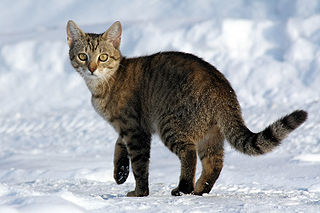

In [30]:
PIL.Image.open(cat_in_snow)

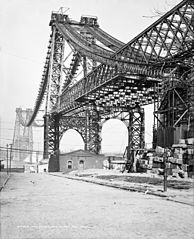

In [31]:
PIL.Image.open(williamsburg_bridge)

In [32]:
image_labels = {cat_in_snow : 0,
                williamsburg_bridge : 1}

In [33]:
image_string = open(cat_in_snow, 'rb').read()
label = image_labels[cat_in_snow]

def image_ex(image_string, label):
    image_shape = tf.io.decode_jpeg(image_string).shape

    feature = {
        'height' : _int64_feature(image_shape[0]),
        'width' : _int64_feature(image_shape[1]),
        'depth' : _int64_feature(image_shape[2]),
        'label' : _int64_feature(label),
        'image_raw' : _bytes_feature(image_string)
    }
    return tf.train.Example(features = tf.train.Features(feature=feature))

In [34]:
for line in str(image_ex(image_string, label)).split('\n')[:15]:
    print(line)
print('...')

features {
  feature {
    key: "depth"
    value {
      int64_list {
        value: 3
      }
    }
  }
  feature {
    key: "height"
    value {
      int64_list {
        value: 213
      }
...


In [35]:
record_file = 'images.tfrecords'
with tf.io.TFRecordWriter(record_file) as writer:
    for filename, label in image_labels.items():
        image_string = open(filename, 'rb').read()
        tf_ex = image_ex(image_string, label)
        writer.write(tf_ex.SerializeToString())

In [38]:
raw_image_dataset = tf.data.TFRecordDataset('/content/images.tfrecords')

image_feature_description = {
    'height' : tf.io.FixedLenFeature([], tf.int64),
    'width' : tf.io.FixedLenFeature([], tf.int64),
    'depth' : tf.io.FixedLenFeature([], tf.int64),
    'label' : tf.io.FixedLenFeature([], tf.int64),
    'image_raw' : tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(ex_proto):
    return tf.io.parse_single_example(ex_proto, image_feature_description)

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
parsed_image_dataset

<MapDataset element_spec={'depth': TensorSpec(shape=(), dtype=tf.int64, name=None), 'height': TensorSpec(shape=(), dtype=tf.int64, name=None), 'image_raw': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'width': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

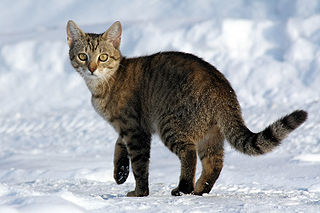

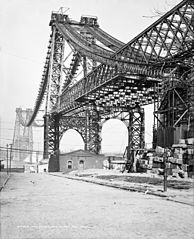

In [39]:
for i in parsed_image_dataset:
   image_raw = i['image_raw'].numpy()
   display.display(display.Image(data=image_raw))